In [2]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install --no-cache-dir scikit-learn imbalanced-learn

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 243.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 295.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint


In [2]:
final_data = pd.read_csv("final_data_price_news.csv",parse_dates=["Adjusted_Date"])

In [3]:
final_data.drop(columns=['Unnamed: 0'],errors='ignore', inplace=True)

In [4]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Stock_Name      1605 non-null   object        
 1   Adjusted_Date   1605 non-null   datetime64[ns]
 2   Open            1605 non-null   float64       
 3   High            1605 non-null   float64       
 4   Low             1605 non-null   float64       
 5   Close           1605 non-null   float64       
 6   Volume          1605 non-null   int64         
 7   Dividends       1605 non-null   float64       
 8   Stock Splits    1605 non-null   float64       
 9   Label           1605 non-null   int64         
 10  negative_score  1605 non-null   float64       
 11  neutral_score   1605 non-null   float64       
 12  positive_score  1605 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 163.1+ KB


In [5]:
valid_stock_names = final_data["Stock_Name"].value_counts()
valid_stock_names = valid_stock_names[valid_stock_names > 3].index

# Filter the DataFrame to include only valid stock names
final_data = final_data[final_data["Stock_Name"].isin(valid_stock_names)]

# Display the updated value counts to verify
print(final_data["Stock_Name"].value_counts())

Stock_Name
LUPIN.NS         82
TATAPOWER.NS     79
HDFCBANK.NS      78
ITC.NS           77
IRCTC.NS         77
INFY.NS          74
SBIN.NS          73
TITAN.NS         73
STARHEALTH.NS    72
VEDL.NS          72
ONGC.NS          71
ASIANPAINT.NS    70
LICI.NS          69
TCS.NS           67
COCHINSHIP.NS    67
PAYTM.NS         67
RELIANCE.NS      67
ZOMATO.NS        66
ADANIENT.NS      65
TECHM.NS         62
AUROPHARMA.NS    57
DMART.NS         55
HYUNDAI.NS       45
NTPCGREEN.NS     20
Name: count, dtype: int64


In [6]:

def split_time_series_data(data, data_set_1_size=0.8):
    # Step 1: Group by Stock_Name
    grouped = data.groupby("Stock_Name")

    # Step 2: Create empty lists to hold train and test data
    train_data = []
    test_data = []

    # Step 3: Loop through each stock group
    for stock_name, group in grouped:
        # Step 4: Sort the data by Date (ascending order)
        group = group.sort_values("Adjusted_Date")

        # Step 5: Split into 80% train and 20% test
        train_size = int(len(group) * 0.8)  # 80% of the data

        # The train and test datasets for this stock
        stock_train = group[:train_size]
        stock_test = group[train_size:]

        # Append to the train and test lists
        train_data.append(stock_train)
        test_data.append(stock_test)

    # Step 6: Concatenate all train and test data back into single DataFrames
    train_data = pd.concat(train_data, axis=0)
    test_data = pd.concat(test_data, axis=0)

    # Step 7: (Optional) Reset index for train and test datasets
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)

    return train_data, test_data

In [7]:
train_data , test_data = split_time_series_data(final_data)

print(f"train data shape {train_data.shape}")
print(f"test data shape {test_data.shape}")

train data shape (1274, 13)
test data shape (331, 13)


In [8]:
all_counts = final_data['Stock_Name'].value_counts().reset_index()
train_counts = train_data['Stock_Name'].value_counts().reset_index()
test_counts = test_data['Stock_Name'].value_counts().reset_index()

# Rename columns for better clarity
all_counts.columns = ['Stock_Name','Total_count']
train_counts.columns = ['Stock_Name', 'Train_Count']
test_counts.columns = ['Stock_Name', 'Test_Count']

# Merge the first two DataFrames
stock_counts = pd.merge(all_counts, train_counts, on='Stock_Name', how='outer')

# Merge the result with the third DataFrame
stock_counts = pd.merge(stock_counts, test_counts, on='Stock_Name', how='outer')

# Print the result in tabular format
stock_counts

,Stock_Name,Total_count,Train_Count,Test_Count
0,ADANIENT.NS,65,52,13
1,ASIANPAINT.NS,70,56,14
2,AUROPHARMA.NS,57,45,12
3,COCHINSHIP.NS,67,53,14
4,DMART.NS,55,44,11
5,HDFCBANK.NS,78,62,16
6,HYUNDAI.NS,45,36,9
7,INFY.NS,74,59,15
8,IRCTC.NS,77,61,16
9,ITC.NS,77,61,16


In [9]:
train_data.head()

,Stock_Name,Adjusted_Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,negative_score,neutral_score,positive_score
0,ADANIENT.NS,2024-09-02,3021.100098,3059.149902,2997.600098,3042.149902,1842658,0.0,0.0,-1,0.992560,0.004107,0.003333
1,ADANIENT.NS,2024-09-03,3037.000000,3053.050049,3023.800049,3036.100098,1371577,0.0,0.0,-1,0.972357,0.023498,0.004145
2,ADANIENT.NS,2024-09-04,3010.000000,3025.000000,2955.199951,3012.350098,1212270,0.0,0.0,1,0.991823,0.005121,0.003057
3,ADANIENT.NS,2024-09-05,3025.000000,3037.899902,3002.000000,3015.350098,734273,0.0,0.0,1,0.731447,0.252796,0.015757
4,ADANIENT.NS,2024-09-06,3019.000000,3025.000000,2968.000000,2975.449951,1251165,0.0,0.0,-1,0.991486,0.005457,0.003058


In [10]:
test_data.head(10)

,Stock_Name,Adjusted_Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,negative_score,neutral_score,positive_score
0,ADANIENT.NS,2024-12-12,2457.000000,2534.800049,2446.250000,2504.100098,2579624,0.0,0.0,1,0.990830,0.006196,0.002974
1,ADANIENT.NS,2024-12-13,2504.000000,2545.000000,2479.050049,2527.550049,1940935,0.0,0.0,1,0.985375,0.011183,0.003442
2,ADANIENT.NS,2024-12-16,2530.000000,2537.500000,2503.000000,2512.399902,654321,0.0,0.0,-1,0.858586,0.129195,0.012219
3,ADANIENT.NS,2024-12-17,2512.000000,2525.000000,2480.750000,2487.600098,1061891,0.0,0.0,-1,0.989909,0.006657,0.003434
4,ADANIENT.NS,2024-12-18,2489.000000,2496.600098,2452.000000,2457.399902,990217,0.0,0.0,-1,0.974408,0.020960,0.004632
5,ADANIENT.NS,2024-12-19,2429.000000,2434.000000,2397.100098,2419.350098,1181898,0.0,0.0,1,0.991128,0.005801,0.003071
6,ADANIENT.NS,2024-12-20,2429.000000,2453.850098,2333.000000,2344.949951,1337016,0.0,0.0,1,0.990663,0.006402,0.002935
7,ADANIENT.NS,2024-12-23,2373.949951,2379.500000,2332.750000,2338.949951,758920,0.0,0.0,1,0.990979,0.005592,0.003429
8,ADANIENT.NS,2024-12-26,2378.050049,2410.000000,2368.000000,2400.250000,895785,0.0,0.0,1,0.075033,0.863305,0.061662
9,ADANIENT.NS,2024-12-27,2415.000000,2446.149902,2390.500000,2409.949951,1982291,0.0,0.0,1,0.988380,0.008048,0.003571


In [11]:
X_train = train_data.drop(['Stock_Name', 'Adjusted_Date','Label'], axis=1)
y_train = train_data['Label']

X_test = test_data.drop(['Stock_Name', 'Adjusted_Date','Label'], axis=1)
y_test = test_data['Label']

In [12]:
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1274, 10)
y_train shape (1274,)
X_test shape (331, 10)
y_test shape (331,)


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Fix Class Labels (-1 → 2)
y_train = np.where(y_train == -1, 2, y_train)
y_test = np.where(y_test == -1, 2, y_test)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}

# Define models with class balancing
models = {
    "Logistic Regression": LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight=class_weight_dict),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "SGD Classifier": SGDClassifier(loss='log_loss', class_weight=class_weight_dict, random_state=42),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Gaussian Process Classifier": GaussianProcessClassifier(random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(classification_report(y_test, y_pred, zero_division=1))

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)


Training Logistic Regression...
Logistic Regression - Accuracy: 0.4864, Precision: 0.5556, Recall: 0.4864, F1-Score: 0.5070

Confusion Matrix:
[[15  7  2]
 [29 71 48]
 [37 47 75]]
              precision    recall  f1-score   support

           0       0.19      0.62      0.29        24
           1       0.57      0.48      0.52       148
           2       0.60      0.47      0.53       159

    accuracy                           0.49       331
   macro avg       0.45      0.53      0.44       331
weighted avg       0.56      0.49      0.51       331

Training Random Forest...
Random Forest - Accuracy: 0.5257, Precision: 0.5326, Recall: 0.5257, F1-Score: 0.4967

Confusion Matrix:
[[  3   9  12]
 [  0 116  32]
 [  3 101  55]]
              precision    recall  f1-score   support

           0       0.50      0.12      0.20        24
           1       0.51      0.78      0.62       148
           2       0.56      0.35      0.43       159

    accuracy                           0.53 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.5106, Precision: 0.5108, Recall: 0.5106, F1-Score: 0.4968

Confusion Matrix:
[[  4  11   9]
 [  4 102  42]
 [  6  90  63]]
              precision    recall  f1-score   support

           0       0.29      0.17      0.21        24
           1       0.50      0.69      0.58       148
           2       0.55      0.40      0.46       159

    accuracy                           0.51       331
   macro avg       0.45      0.42      0.42       331
weighted avg       0.51      0.51      0.50       331

Training Linear Discriminant Analysis...
Linear Discriminant Analysis - Accuracy: 0.4713, Precision: 0.4917, Recall: 0.4713, F1-Score: 0.3854

Confusion Matrix:
[[  0  24   0]
 [  0 132  16]
 [  1 134  24]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.46      0.89      0.60       148
           2       0.60      0.15      0.24       159

    accuracy                           0.47      

###Observations:
Here are some key observations based on the model performances:

1. **Logistic Regression**:
   - Achieves **48.64% accuracy**, slightly lower than Random Forest and XGBoost.
   - The confusion matrix indicates that it predicts only one class (0) correctly and fails to classify the others.
   - Precision is high because it assigns all predictions to one class, but recall is extremely low.

2. **Random Forest**:
   - Achieves **52.56% accuracy**, which is one of the better results.
   - The confusion matrix shows that it predicts class 1 relatively well but struggles with class 0 and 2.
   - Balanced performance across precision, recall, and F1-score.

3. **SVM**:
   - Accuracy is **34.14%**, which is lower than Random Forest.
   - Performs poorly in classifying class 1 correctly, with a recall of only 6%.
   - Class 2 has better recall (57%) but at the cost of misclassifying other classes.

4. **XGBoost**:
   - Similar to Random Forest, with **51.06% accuracy**.
   - Precision, recall, and F1-score are quite balanced.
   - Performs better than SVM and Logistic Regression.

5. **Linear Discriminant Analysis (LDA)**:
   - **47.13% accuracy**, slightly lower than Random Forest and XGBoost.
   - Class 1 is classified well, but class 0 and 2 suffer.

6. **SGD Classifier**:
   - **44.71% accuracy**, slightly lower than LDA.
   - Only predicts class 1 correctly, failing to classify the other two.
   - High precision but low recall, meaning it's predicting one class well but missing others.

7. **K-Neighbors Classifier (KNN)**:
   - **48.94% accuracy**, slightly better than SGD.
   - Precision and recall are more balanced.
   - Misclassifications exist but better distribution than SGD.

8. **Gaussian Process Classifier**:
   - **48.04% accuracy**, slightly worse than KNN.
   - Predicts class 2 very well but fails in classifying class 0 and 1.
   - High precision but low recall, meaning it predicts a single class more frequently.

### **Overall Insights:**
- **Random Forest and XGBoost are the best-performing models**, with around **52% accuracy**.
- **SVM is the worst model**, failing to classify anything properly.
- **Logistic Regression and LDA struggle with class distribution**, leading to lower recall and F1-scores.
- **SGD and Gaussian Process tend to predict only a single class correctly**, leading to misleading precision values.

In [18]:
# ----------------------------
# Hyperparameter tuning for Random Forest
# ----------------------------
rf_params = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

rf_random_randomsearch = RandomizedSearchCV(
    RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
    param_distributions=rf_params,
    n_iter=50,  # Number of iterations
    scoring="accuracy",
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    random_state=42
)

rf_random_randomsearch.fit(X_train, y_train)
best_rf_randomsearch = rf_random_randomsearch.best_estimator_
print("Best Random Forest Parameters:", rf_random_randomsearch.best_params_)

Best Random Forest Parameters: {'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 179}


In [19]:
# ----------------------------
# Hyperparameter tuning for Random Forest
# ----------------------------
rf_param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees in the forest
    "max_depth": [5, 10, 20],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples required to split a node
    "min_samples_leaf": [1, 2, 4],  # Min samples required at a leaf node
    "max_features": ["sqrt", "log2"]  # Number of features considered for split
}

rf_grid_gridsearch = GridSearchCV(
    RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
    param_grid=rf_param_grid,
    scoring="accuracy",
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=2
)

rf_grid_gridsearch.fit(X_train, y_train)
best_rf_gridsearch = rf_grid_gridsearch.best_estimator_
print("Best Random Forest Parameters:", rf_grid_gridsearch.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Random Forest Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [20]:
# ----------------------------
# Hyperparameter tuning for XGBoost
# ----------------------------
xgb_params = {
    "n_estimators": randint(50, 500),
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "max_depth": randint(3, 30),
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": randint(0, 10)
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=xgb_params,
    n_iter=50,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train, y_train)
best_xgb_randomsearch = xgb_random.best_estimator_
print("Best XGBoost Parameters:", xgb_random.best_params_)

Best XGBoost Parameters: {'colsample_bytree': 0.9, 'gamma': 7, 'learning_rate': 0.3, 'max_depth': 23, 'n_estimators': 152, 'subsample': 0.7}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:08:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
# ----------------------------
# Hyperparameter tuning for XGBoost
# ----------------------------
xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 6, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2
)

xgb_grid.fit(X_train, y_train)
best_xgb_gridsearch = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
# ----------------------------
# Evaluating the best models
# ----------------------------
models = {
    "Best Random Forest": best_rf_randomsearch,
    "Best XGBoost": best_xgb_randomsearch
}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")



Evaluating Best Random Forest...
Best Random Forest - Accuracy: 0.5136, Precision: 0.5194, Recall: 0.5136, F1-Score: 0.4935


Evaluating Best XGBoost...
Best XGBoost - Accuracy: 0.4471, Precision: 0.7528, Recall: 0.4471, F1-Score: 0.2763



In [23]:
# ----------------------------
# Evaluating the Best Models
# ----------------------------
models = {
    "Best Random Forest": best_rf_gridsearch,
    "Best XGBoost": best_xgb_gridsearch
}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")


Evaluating Best Random Forest...
Best Random Forest - Accuracy: 0.4894, Precision: 0.4891, Recall: 0.4894, F1-Score: 0.4590


Evaluating Best XGBoost...
Best XGBoost - Accuracy: 0.4471, Precision: 0.7528, Recall: 0.4471, F1-Score: 0.2763



In [24]:
import pickle

with open('best_model_classification.pkl', 'wb') as f:
    pickle.dump(best_rf_randomsearch, f)

print("Best model saved to best_model_classification.pkl")

Best model saved to best_model_classification.pkl


X_seq_train shape: (1264, 10, 7), y_seq_train shape: (1264,)
X_seq_test shape: (321, 10, 7), y_seq_test shape: (321,)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3540 - loss: 1.3047 - val_accuracy: 0.4393 - val_loss: 1.0103
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4542 - loss: 1.1248 - val_accuracy: 0.4393 - val_loss: 0.9659
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4544 - loss: 1.0831 - val_accuracy: 0.4486 - val_loss: 0.9564
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4647 - loss: 1.0641 - val_accuracy: 0.4393 - val_loss: 0.9596
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5087 - loss: 0.9649 - val_accuracy: 0.4393 - val_loss: 0.9785
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4990 - loss: 0.9512 - val_accuracy: 0.4548 - val_loss: 0.9611
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4920 - loss: 0.9641 - val_accuracy: 0.4361 - val_loss: 0.9681
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4809 - loss: 0.9614 - val_accuracy: 0.4642 - val_loss: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 128)             │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 359,243 (1.37 MB)

 Trainable params: 119,619 (467.26 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 239,240 (934.54 KB)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
LSTM Classification Model Accuracy: 0.4268

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.07      0.12       156
           1       0.00      0.00      0.00        24
           2       0.43      0.89      0.58       141

    accuracy                           0.43       321
   macro avg       0.29      0.32      0.23       321
weighted avg       0.40      0.43      0.31       321


Confusion Matrix:
[[ 11   2 143]
 [  0   0  24]
 [ 14   1 126]]


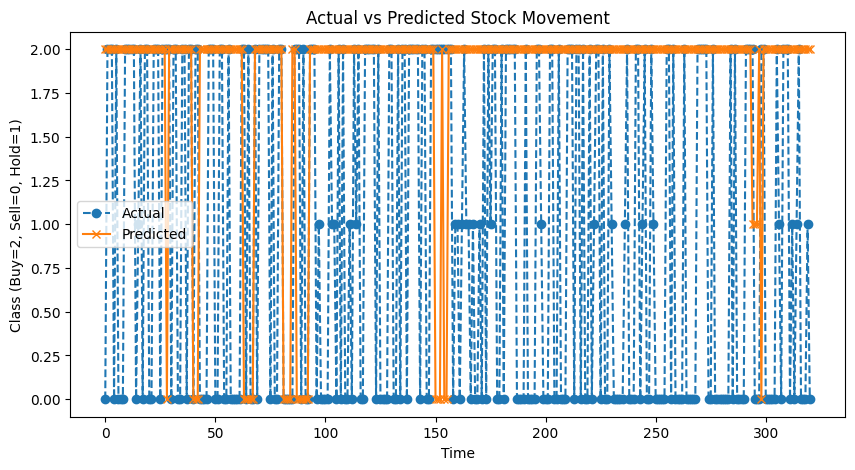

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Encode 'Label' (-1, 0, 1) as (0, 1, 2) for multi-class classification
label_encoder = LabelEncoder()
final_data['Target'] = label_encoder.fit_transform(final_data['Label'])

# Split Data
train_data_lstm, test_data_lstm = split_time_series_data(final_data)

# Prepare Features and Labels
features = ['Open', 'High', 'Low', 'Close', 'negative_score', 'neutral_score', 'positive_score']
X_train, y_train = train_data_lstm[features].values, train_data_lstm['Target'].values
X_test, y_test = test_data_lstm[features].values, test_data_lstm['Target'].values

# Scale Features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Convert to Time-Series Format
sequence_length = 10
X_seq_train, y_seq_train, X_seq_test, y_seq_test = [], [], [], []

# Create sequences for training
for i in range(len(X_train) - sequence_length):
    X_seq_train.append(X_train[i:i + sequence_length])
    y_seq_train.append(y_train[i + sequence_length])

# Create sequences for testing
for i in range(len(X_test) - sequence_length):
    X_seq_test.append(X_test[i:i + sequence_length])
    y_seq_test.append(y_test[i + sequence_length])

# Convert to NumPy Arrays
X_seq_train, y_seq_train = np.array(X_seq_train), np.array(y_seq_train)
X_seq_test, y_seq_test = np.array(X_seq_test), np.array(y_seq_test)

print(f"X_seq_train shape: {X_seq_train.shape}, y_seq_train shape: {y_seq_train.shape}")
print(f"X_seq_test shape: {X_seq_test.shape}, y_seq_test shape: {y_seq_test.shape}")

# Define LSTM Model for Multi-Class Classification
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, X_seq_train.shape[2])),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3-class classification (Buy, Sell, Hold)
])

# Compile Model
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_seq_train, y_seq_train, epochs=50, batch_size=16, validation_data=(X_seq_test, y_seq_test))

# Model Summary
model.summary()

# Predictions
y_pred = model.predict(X_seq_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Evaluation Metrics
accuracy = accuracy_score(y_seq_test, y_pred_labels)
print(f"LSTM Classification Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_seq_test, y_pred_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(y_seq_test, y_pred_labels))

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(y_seq_test, label='Actual', marker='o', linestyle='dashed')
plt.plot(y_pred_labels, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Stock Movement")
plt.xlabel("Time")
plt.ylabel("Class (Buy=2, Sell=0, Hold=1)")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.4512 - loss: 2.7617 - val_accuracy: 0.1223 - val_loss: 1.2712
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4515 - loss: 1.8210 - val_accuracy: 0.1191 - val_loss: 1.5019
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4218 - loss: 1.7207 - val_accuracy: 0.1912 - val_loss: 1.8858
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4507 - loss: 1.5035 - val_accuracy: 0.2508 - val_loss: 1.8225
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4752 - loss: 1.4863 - val_accuracy: 0.2194 - val_loss: 2.3386
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4522 - loss: 1.4400 - val_accuracy: 0.1850 - val_loss: 2.0866
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4750 - loss: 1.3871 - val_accuracy: 0.1724 - val_loss: 2.0233
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4581 - loss: 1.3788 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 128)             │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,387 (1.39 MB)

 Trainable params: 121,667 (475.26 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 243,336 (950.54 KB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Classification Model Accuracy: 0.4044

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.55       155
           1       0.10      0.33      0.15        24
           2       0.45      0.25      0.32       140

    accuracy                           0.40       319
   macro avg       0.36      0.38      0.34       319
weighted avg       0.47      0.40      0.42       319


Confusion Matrix:
[[86 33 36]
 [ 9  8  7]
 [64 41 35]]


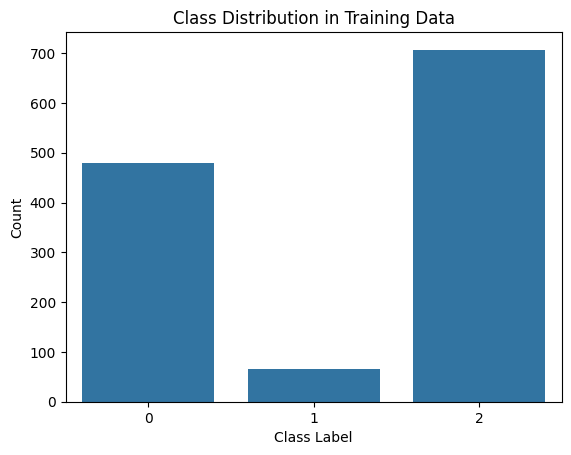

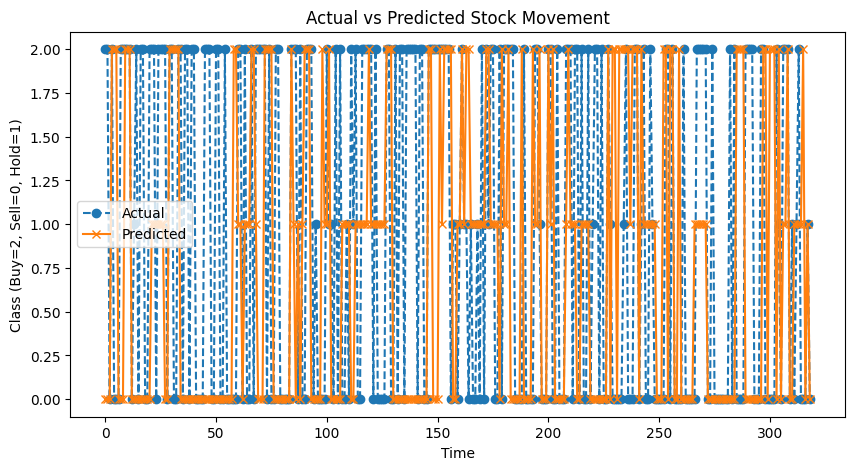

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Encode 'Label' (-1, 0, 1) as (0, 1, 2) for multi-class classification
label_encoder = LabelEncoder()
final_data['Target'] = label_encoder.fit_transform(final_data['Label'])

# Feature Engineering
final_data['SMA_10'] = final_data['Close'].rolling(10).mean()
final_data['RSI_14'] = compute_rsi(final_data['Close'], 14)
final_data['MACD'], final_data['Signal_Line'] = compute_macd(final_data['Close'])
final_data.dropna(inplace=True)  # Drop NaN values after feature computation

# Split Data
train_data_lstm, test_data_lstm = split_time_series_data(final_data)

# Prepare Features and Labels
features = ['Open', 'High', 'Low', 'Close', 'negative_score', 'neutral_score', 'positive_score', 'SMA_10', 'RSI_14', 'MACD', 'Signal_Line']
X_train, y_train = train_data_lstm[features].values, train_data_lstm['Target'].values
X_test, y_test = test_data_lstm[features].values, test_data_lstm['Target'].values

# Scale Features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Convert to Time-Series Format
sequence_length = 10
X_seq_train, y_seq_train, X_seq_test, y_seq_test = [], [], [], []

for i in range(len(X_train) - sequence_length):
    X_seq_train.append(X_train[i:i + sequence_length])
    y_seq_train.append(y_train[i + sequence_length])

for i in range(len(X_test) - sequence_length):
    X_seq_test.append(X_test[i:i + sequence_length])
    y_seq_test.append(y_test[i + sequence_length])

X_seq_train, y_seq_train = np.array(X_seq_train), np.array(y_seq_train)
X_seq_test, y_seq_test = np.array(X_seq_test), np.array(y_seq_test)

# Convert labels to One-Hot Encoding
y_seq_train_onehot = to_categorical(y_seq_train, num_classes=3)
y_seq_test_onehot = to_categorical(y_seq_test, num_classes=3)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq_train), y=y_seq_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Apply SMOTE for Oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_seq_train.reshape(X_seq_train.shape[0], -1), y_seq_train)
X_seq_train_resampled = X_train_resampled.reshape(-1, sequence_length, X_seq_train.shape[2])
y_seq_train_resampled_onehot = to_categorical(y_train_resampled, num_classes=3)

# Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, X_seq_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='sigmoid')  # Multi-label classification with sigmoid activation
])

# Compile Model
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_seq_train_resampled, y_seq_train_resampled_onehot, epochs=50, batch_size=16, validation_data=(X_seq_test, y_seq_test_onehot), class_weight=class_weights)

# Model Summary
model.summary()

# Predictions
y_pred = model.predict(X_seq_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Evaluation Metrics
accuracy = accuracy_score(y_seq_test, y_pred_labels)
print(f"LSTM Classification Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_seq_test, y_pred_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(y_seq_test, y_pred_labels))

# Plot Class Distribution
train_class_counts = np.unique(y_seq_train, return_counts=True)
sns.barplot(x=train_class_counts[0], y=train_class_counts[1])
plt.title("Class Distribution in Training Data")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(y_seq_test, label='Actual', marker='o', linestyle='dashed')
plt.plot(y_pred_labels, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Stock Movement")
plt.xlabel("Time")
plt.ylabel("Class (Buy=2, Sell=0, Hold=1)")
plt.show()


Epoch [1/50], Loss: 1.0868, Accuracy: 0.4126
Epoch [2/50], Loss: 1.0216, Accuracy: 0.4781
Epoch [3/50], Loss: 0.9547, Accuracy: 0.5076
Epoch [4/50], Loss: 0.8945, Accuracy: 0.5371
Epoch [5/50], Loss: 0.8745, Accuracy: 0.5395
Epoch [6/50], Loss: 0.8565, Accuracy: 0.5531
Epoch [7/50], Loss: 0.8439, Accuracy: 0.5603
Epoch [8/50], Loss: 0.8411, Accuracy: 0.5619
Epoch [9/50], Loss: 0.8350, Accuracy: 0.5563
Epoch [10/50], Loss: 0.8312, Accuracy: 0.5611
Epoch [11/50], Loss: 0.8332, Accuracy: 0.5587
Epoch [12/50], Loss: 0.8381, Accuracy: 0.5531
Epoch [13/50], Loss: 0.8391, Accuracy: 0.5563
Epoch [14/50], Loss: 0.8255, Accuracy: 0.5587
Epoch [15/50], Loss: 0.8310, Accuracy: 0.5611
Epoch [16/50], Loss: 0.8335, Accuracy: 0.5595
Epoch [17/50], Loss: 0.8308, Accuracy: 0.5515
Epoch [18/50], Loss: 0.8310, Accuracy: 0.5611
Epoch [19/50], Loss: 0.8265, Accuracy: 0.5603
Epoch [20/50], Loss: 0.8268, Accuracy: 0.5611
Epoch [21/50], Loss: 0.8337, Accuracy: 0.5603
Epoch [22/50], Loss: 0.8335, Accuracy: 0.55

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


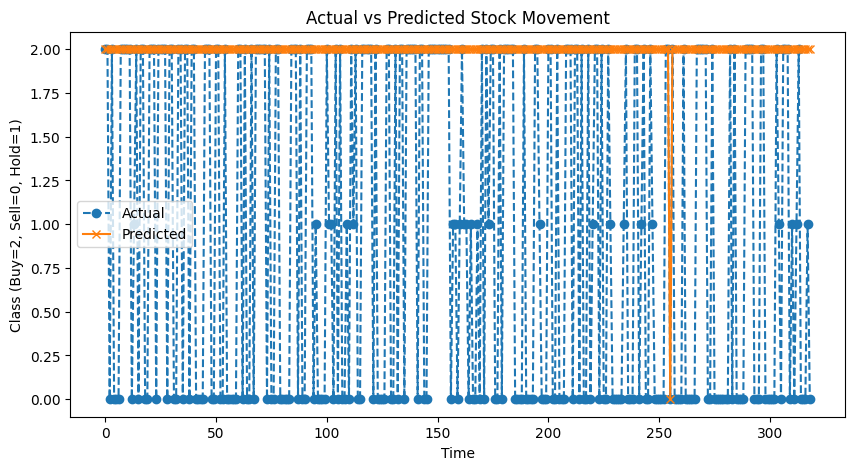

In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Encode Labels (-1, 0, 1) to (0, 1, 2)
label_encoder = LabelEncoder()
final_data['Target'] = label_encoder.fit_transform(final_data['Label'])

# Split Data
train_data_lstm, test_data_lstm = split_time_series_data(final_data)

# Prepare Features and Labels
features = ['Open', 'High', 'Low', 'Close', 'negative_score', 'neutral_score', 'positive_score']
X_train, y_train = train_data_lstm[features].values, train_data_lstm['Target'].values
X_test, y_test = test_data_lstm[features].values, test_data_lstm['Target'].values

# Scale Features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Convert to Time-Series Format
sequence_length = 10
X_seq_train, y_seq_train, X_seq_test, y_seq_test = [], [], [], []

# Create sequences for training
for i in range(len(X_train) - sequence_length):
    X_seq_train.append(X_train[i:i + sequence_length])
    y_seq_train.append(y_train[i + sequence_length])

# Create sequences for testing
for i in range(len(X_test) - sequence_length):
    X_seq_test.append(X_test[i:i + sequence_length])
    y_seq_test.append(y_test[i + sequence_length])

# Convert to NumPy Arrays
X_seq_train, y_seq_train = np.array(X_seq_train), np.array(y_seq_train)
X_seq_test, y_seq_test = np.array(X_seq_test), np.array(y_seq_test)

# Convert to Torch Tensors
X_seq_train = torch.tensor(X_seq_train, dtype=torch.float32)
y_seq_train = torch.tensor(y_seq_train, dtype=torch.long)  # Use long dtype for classification
X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
y_seq_test = torch.tensor(y_seq_test, dtype=torch.long)

# Define Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 16
train_dataset = TimeSeriesDataset(X_seq_train, y_seq_train)
test_dataset = TimeSeriesDataset(X_seq_test, y_seq_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step
        lstm_out = self.batch_norm(lstm_out)
        return self.fc(lstm_out)

# Model Parameters
input_size = X_seq_train.shape[2]
hidden_size = 128
output_size = 3  # 3 classes (Buy, Sell, Hold)
num_layers = 2

# Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPredictor(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct, total = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

# Evaluation
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())

# Metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nPyTorch LSTM Classification Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual', marker='o', linestyle='dashed')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Stock Movement")
plt.xlabel("Time")
plt.ylabel("Class (Buy=2, Sell=0, Hold=1)")
plt.show()


In [15]:
# Save the trained model
torch.save(model.state_dict(), "lstm_model_classification.pkl")
print("Model saved successfully as lstm_stock_model.pkl")


Model saved successfully as lstm_stock_model.pkl
